In [156]:
#This ipynb was developed on Google Colab and uses file from Google Drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


#### Importing Libraries & Loading Data

In [157]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import re
from bs4 import BeautifulSoup
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer
from nltk.stem import PorterStemmer

!pip install thefuzz
from thefuzz import fuzz

from wordcloud import WordCloud, STOPWORDS
from os import path

from sklearn.preprocessing import MinMaxScaler

%matplotlib inline

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [158]:
parent_folder = "/content/drive/MyDrive/AAIC/Projects/Quora Question Pairs"
filename = "train_fe_1.csv"
df = pd.read_csv(parent_folder + "/" + filename)

In [159]:
df.head(2)

,Unnamed: 0,id,qid1,qid2,question1,question2,is_duplicate,length_difference,unique_length_difference,common_words_count,common_words_share
0,0,0,1,2,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0,2,1,10,0.434783
1,1,1,3,4,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0,5,4,4,0.200000


#### Text Cleaning Function

In [160]:
stop_words = stopwords.words("english")
len(stop_words)

179

In [161]:
def clean_text(text, to_stem = False):
    stop_words = stopwords.words("english")

    # expanding contradictions : https://stackoverflow.com/questions/19790188/expanding-english-language-contractions-in-python/47091490
    def decontracted(phrase):
        # specific
        phrase = re.sub(r"won't", "will not", phrase)
        phrase = re.sub(r"can\'t", "can not", phrase)

        # general
        phrase = re.sub(r"n\'t", " not", phrase)
        phrase = re.sub(r"\'re", " are", phrase)
        phrase = re.sub(r"\'s", " is", phrase)
        phrase = re.sub(r"\'d", " would", phrase)
        phrase = re.sub(r"\'ll", " will", phrase)
        phrase = re.sub(r"\'t", " not", phrase)
        phrase = re.sub(r"\'ve", " have", phrase)
        phrase = re.sub(r"\'m", " am", phrase)
        return phrase

    
    # converting to lower case
    cleaned_text = str(text).lower()
    
    # remove urls from the sentence : https://stackoverflow.com/questions/11331982/how-to-remove-any-url-within-a-string-in-python/40823105
    cleaned_text = re.sub(r"http\S+", "", cleaned_text)

    # remove html tags from sentence : https://stackoverflow.com/questions/16206380/python-beautifulsoup-how-to-remove-all-tags-from-an-element
    cleaned_text = BeautifulSoup(cleaned_text, 'lxml').get_text()

    # decontract sentence
    cleaned_text = decontracted(cleaned_text)

    # replace big numbers' zeros with m (Million) and k (Thousand)
    cleaned_text = re.sub(r"([0-9]+)000000", r"\1m", cleaned_text)
    cleaned_text = re.sub(r"([0-9]+)000", r"\1k", cleaned_text)

    # remove special characters : https://stackoverflow.com/questions/5843518/remove-all-special-characters-punctuation-and-spaces-from-string/5843547
    cleaned_text = re.sub('[^A-Za-z0-9]+', " ", cleaned_text)

    # remove stopwords
    # skipping this for now
    """
    cleaned_text = ' '.join(word.lower() for word in cleaned_text.split() if word.lower() not in stop_words)
    """

    # stemming
    # skipping this for now
    """
    if to_stem:
        stemmer = SnowballStemmer(language="english")
        cleaned_text = ' '.join([stemmer.stem(word) for word in cleaned_text.split()])
    """

    return cleaned_text

#### Cleaning question1 and question2 texts

In [162]:
print(df.iloc[:5]['question1'].values)
print()
print(df.iloc[:5]['question2'].values)

['What is the step by step guide to invest in share market in india?'
 'What is the story of Kohinoor (Koh-i-Noor) Diamond?'
 'How can I increase the speed of my internet connection while using a VPN?'
 'Why am I mentally very lonely? How can I solve it?'
 'Which one dissolve in water quikly sugar, salt, methane and carbon di oxide?']

['What is the step by step guide to invest in share market?'
 'What would happen if the Indian government stole the Kohinoor (Koh-i-Noor) diamond back?'
 'How can Internet speed be increased by hacking through DNS?'
 'Find the remainder when [math]23^{24}[/math] is divided by 24,23?'
 'Which fish would survive in salt water?']


In [163]:
df['question1'] = df['question1'].apply(clean_text)
df['question2'] = df['question2'].apply(clean_text)

/usr/local/lib/python3.7/dist-packages/bs4/__init__.py:273: UserWarning: "b'.'" looks like a filename, not markup. You should probably open this file and pass the filehandle into Beautiful Soup.
  ' Beautiful Soup.' % markup)


In [164]:
print(df.iloc[:5]['question1'].values)
print()
print(df.iloc[:5]['question2'].values)

['what is the step by step guide to invest in share market in india '
 'what is the story of kohinoor koh i noor diamond '
 'how can i increase the speed of my internet connection while using a vpn '
 'why am i mentally very lonely how can i solve it '
 'which one dissolve in water quikly sugar salt methane and carbon di oxide ']

['what is the step by step guide to invest in share market '
 'what would happen if the indian government stole the kohinoor koh i noor diamond back '
 'how can internet speed be increased by hacking through dns '
 'find the remainder when math 23 24 math is divided by 24 23 '
 'which fish would survive in salt water ']


#### Feature Extraction - 1



*   word -> any word in the sentence
*   stopword -> word which is in NLTK stopwords list
*   non_stopword -> token which is not a stopword
<br>
<br>
<br>




*   **cwc_min** : common_words_count / min(len(q1 words), len(q2_words))
*   **cwc_max** : common_words_count / max(len(q1 words), len(q2_words))
*   **cnc_min** : number of common non_stopwords / min(len(q1 non_stopwords), len(q2 non_stopwords))
*   **cnc_max** : number of common non_stopwords / max(len(q1 non_stopwords), len(q2 non_stopwords))
*   **last_word_equal** : 1 if last word is equal in q1 and q1 else 0
*   **first_word_equal** : 1 if first word is equal in q1 and q1 else 0



In [200]:
def get_word_features(q1, q2):
    STOPWORDS = stopwords.words("english")
    SAFE_DIVIDER = 0.0001
    q1_words = list(map(str,q1.split()))
    q2_words = list(map(str,q2.split()))

    q1_non_stopwords = set([word for word in q1_words if word not in STOPWORDS])
    q2_non_stopwords = set([word for word in q2_words if word not in STOPWORDS])

    common_word_count = len(set(q1_words).intersection(set(q2_words)))

    common_non_stopwords_count = len(q1_non_stopwords.intersection(q2_non_stopwords))

    cwc_min = common_word_count / (np.min([len(q1_words), len(q2_words)]) + SAFE_DIVIDER)
    cwc_max = common_word_count / (np.max([len(q1_words), len(q2_words)]) + SAFE_DIVIDER)

    cnc_min = common_non_stopwords_count / (np.min([len(q1_non_stopwords), len(q2_non_stopwords)]) + SAFE_DIVIDER)
    cnc_max = common_non_stopwords_count / (np.max([len(q1_non_stopwords), len(q2_non_stopwords)]) + SAFE_DIVIDER)

    if len(q1_words)==0 or len(q2_words)==0:
        last_word_equal = 0
        first_word_equal = 0
    else:
        last_word_equal = int(q1_words[-1] == q2_words[-1])
        first_word_equal = int(q1_words[0] == q2_words[0])

    return [cwc_min, cwc_max, cnc_min, cnc_max, last_word_equal, first_word_equal]

In [201]:
word_features = df.apply(lambda row : get_word_features(row['question1'], row['question2']), axis = 1)

In [202]:
print(word_features[0])
print(word_features[99])

[0.9166590278414347, 0.7857086735094749, 0.999980000399992, 0.8333194446759221, 0, 1]
[0.15384497042330444, 0.14285612245626816, 0.249996875039062, 0.249996875039062, 0, 0]


In [203]:
df["cwc_min"] = list(map(lambda x: x[0], word_features))
df["cwc_max"] = list(map(lambda x: x[1], word_features))
df["cnc_min"] = list(map(lambda x: x[2], word_features))
df["cnc_max"] = list(map(lambda x: x[3], word_features))
df["last_word_equal"]  = list(map(lambda x: x[4], word_features))
df["first_word_equal"] = list(map(lambda x: x[5], word_features))

In [204]:
print("Sanity check")
df.iloc[[0,99], -6:]

Sanity check


,cwc_min,cwc_max,cnc_min,cnc_max,last_word_equal,first_word_equal
0,0.916659,0.785709,0.999980,0.833319,0,1
99,0.153845,0.142856,0.249997,0.249997,0,0


#### Feature Extraction - 2

References : <br>
https://chairnerd.seatgeek.com/fuzzywuzzy-fuzzy-string-matching-in-python/ <br>
https://github.com/seatgeek/thefuzz <br><br>


*   fuzz_ratio
*   fuzz_partial_ratio
*   fuzz_token_sort_ratio
*   fuzz_token_set_ratio



In [205]:
df["fuzz_ratio"] = df.apply(lambda row : fuzz.ratio(row['question1'], row['question2']), axis=1)
df["fuzz_partial_ratio"] = df.apply(lambda row : fuzz.partial_ratio(row['question1'], row['question2']), axis=1)
df["fuzz_token_sort_ratio"] = df.apply(lambda row : fuzz.token_sort_ratio(row['question1'], row['question2']), axis=1)
df["fuzz_token_set_ratio"] = df.apply(lambda row : fuzz.token_set_ratio(row['question1'], row['question2']), axis=1)

In [206]:
print("Sanity check")
df.iloc[[0,99], -4:]

Sanity check


,fuzz_ratio,fuzz_partial_ratio,fuzz_token_sort_ratio,fuzz_token_set_ratio
0,93,100,93,100
99,32,32,46,33


#### Analysing Features

##### Word Cloud

In [208]:
df_duplicate = df[df['is_duplicate'] == 1]
df_non_duplicate = df[df['is_duplicate'] == 0]

In [209]:
duplicate_questions = np.dstack([df_duplicate["question1"], df_duplicate["question2"]]).flatten()
non_duplicate_questions = np.dstack([df_non_duplicate["question1"], df_non_duplicate["question2"]]).flatten()

In [210]:
print (f"Number of data points in class 1 (duplicate pairs) : {len(duplicate_questions)}")
print (f"Number of data points in class 0 (non duplicate pairs) : {len(non_duplicate_questions)}")

Number of data points in class 1 (duplicate pairs) : 298526
Number of data points in class 0 (non duplicate pairs) : 510054


In [211]:
# save questions in a text file
np.savetxt(parent_folder + "/" + "train_duplicate.txt", duplicate_questions, delimiter=" ", fmt="%s")
np.savetxt(parent_folder + "/" + "train_non_duplicate.txt", non_duplicate_questions, delimiter=" ", fmt="%s")

In [212]:
text_duplicate_questions = open(path.join(parent_folder, 'train_duplicate.txt')).read()
text_non_duplicate_questions = open(path.join(parent_folder, 'train_non_duplicate.txt')).read()
stop_words_cloud = set(STOPWORDS)

stop_words_cloud.remove("not")
stop_words_cloud.remove("no")
stop_words_cloud.remove("like")

Word Cloud for Duplicate Question pairs


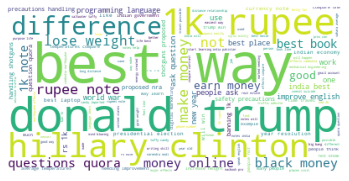

In [213]:
wc = WordCloud(background_color="white", stopwords=stop_words_cloud)
wc.generate(text_duplicate_questions)
print ("Word Cloud for Duplicate Question pairs")
plt.imshow(wc)
plt.axis("off")
plt.show()

Word Cloud for Non-Duplicate Question pairs


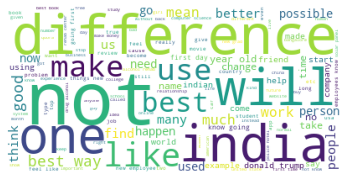

In [214]:
wc = WordCloud(background_color="white", stopwords=stop_words_cloud)
wc.generate(text_non_duplicate_questions)
print ("Word Cloud for Non-Duplicate Question pairs")
plt.imshow(wc)
plt.axis("off")
plt.show()

##### Plots

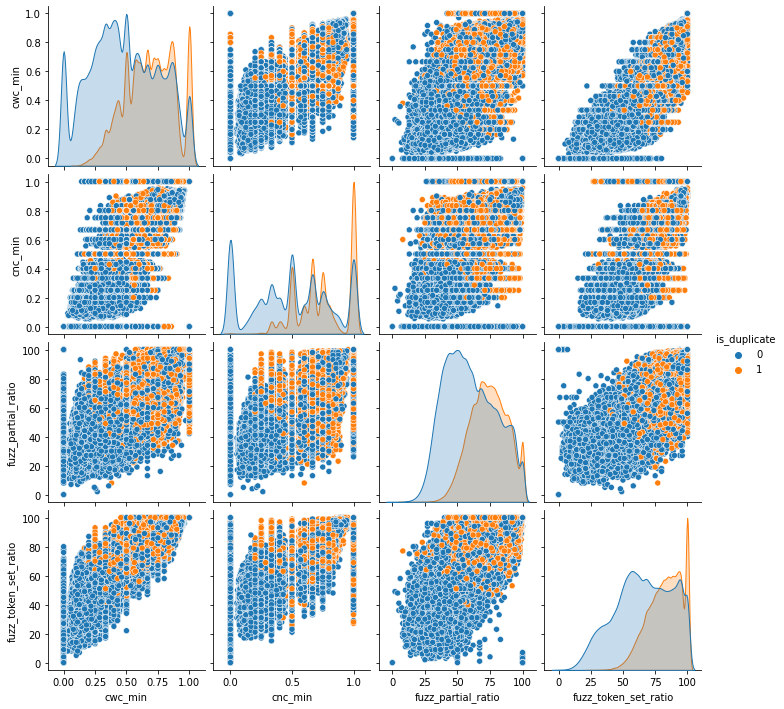

In [215]:
plt.close()

sns.pairplot(data=df, vars=['cwc_min', 'cnc_min', 'fuzz_partial_ratio', 'fuzz_token_set_ratio'], hue='is_duplicate')
plt.show()

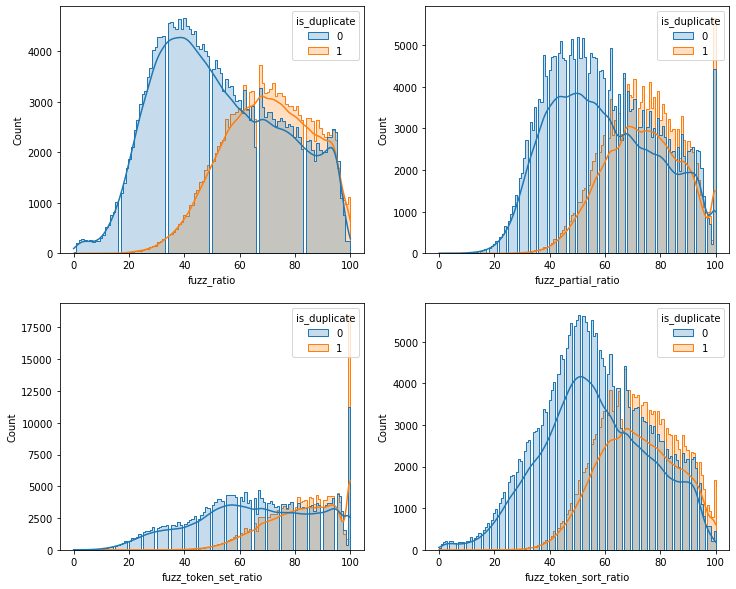

In [216]:
plt.close()
plt.figure(figsize=(12,10))

plt.subplot(2,2,1)
sns.histplot(data=df, x='fuzz_ratio', hue='is_duplicate', element='step', kde=True)

plt.subplot(2,2,2)
sns.histplot(data=df, x='fuzz_partial_ratio', hue='is_duplicate', element='step', kde=True)

plt.subplot(2,2,3)
sns.histplot(data=df, x='fuzz_token_set_ratio', hue='is_duplicate', element='step', kde=True)

plt.subplot(2,2,4)
sns.histplot(data=df, x='fuzz_token_sort_ratio', hue='is_duplicate', element='step', kde=True)

plt.show()

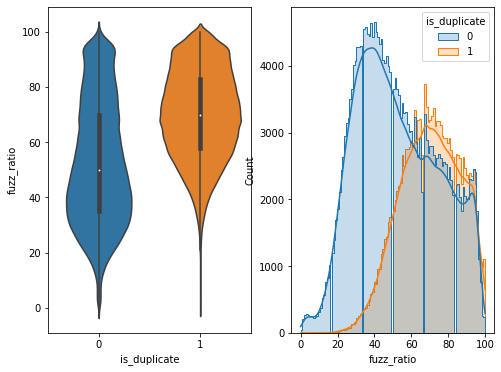

In [217]:
plt.close()
plt.figure(figsize=(8,6))

plt.subplot(1,2,1)
sns.violinplot( data=df, x='is_duplicate', y='fuzz_ratio')

plt.subplot(1,2,2)
sns.histplot(data=df, x='fuzz_ratio', hue='is_duplicate', element='step', kde=True)

plt.show()

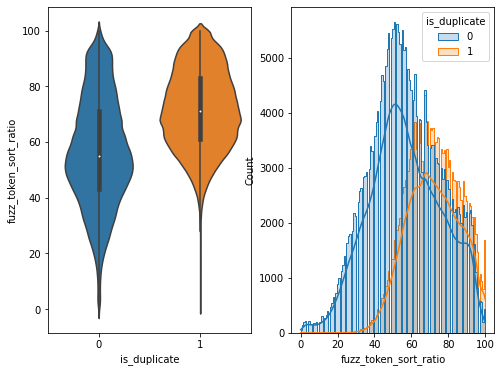

In [218]:
plt.close()
plt.figure(figsize=(8,6))

plt.subplot(1,2,1)
sns.violinplot( data=df, x='is_duplicate', y='fuzz_token_sort_ratio')

plt.subplot(1,2,2)
sns.histplot(data=df, x='fuzz_token_sort_ratio', hue='is_duplicate', element='step', kde=True)

plt.show()

#### Scaling

In [219]:
pd.set_option('display.max_columns', None)
df.head(1)

,Unnamed: 0,id,qid1,qid2,question1,question2,is_duplicate,length_difference,unique_length_difference,common_words_count,common_words_share,cwc_min,cwc_max,cnc_min,cnc_max,last_word_equal,first_word_equal,fuzz_ratio,fuzz_partial_ratio,fuzz_token_sort_ratio,fuzz_token_set_ratio
0,0,0,1,2,what is the step by step guide to invest in sh...,what is the step by step guide to invest in sh...,0,2,1,10,0.434783,0.916659,0.785709,0.99998,0.833319,0,1,93,100,93,100


In [220]:
print("Sanity Check")
min = df['common_words_count'].values.min()
max = df['common_words_count'].values.max()
random_index = 0
x = df['common_words_count'][random_index]

print(f"Common Words Count Min : {min}")
print(f"Common Words Count Max : {max}")
print(f"Random value with index {random_index} : {x}")

x_scaled = (x - min) / (max-min)

print(f"After scaling should be: {x_scaled}")

Sanity Check
Common Words Count Min : 0
Common Words Count Max : 41
Random value with index 0 : 10
After scaling should be: 0.24390243902439024


In [221]:
X = MinMaxScaler().fit_transform(df[['length_difference','unique_length_difference', 'common_words_count', 'common_words_share', 'cwc_min' , 'cwc_max', 'cnc_min' , 'fuzz_ratio' , 'fuzz_partial_ratio' , 'fuzz_token_sort_ratio' , 'fuzz_token_set_ratio']])

In [222]:
# setting the scaled values in the df
df[['length_difference','unique_length_difference', 'common_words_count', 'common_words_share', 'cwc_min' , 'cwc_max', 'cnc_min' , 'fuzz_ratio' , 'fuzz_partial_ratio' , 'fuzz_token_sort_ratio' , 'fuzz_token_set_ratio']] = X

In [223]:
print("Sanity check")
print(f"Value after scaling : {df['common_words_count'][random_index]}")

Sanity check
Value after scaling : 0.24390243902439024


#### Saving the dataframe

In [224]:
df.to_csv(parent_folder + "/" + "train_fe_2.csv")

#### Observations



*   Words like best, way, donald, trump, hillary, clinton occur often in the duplicate question pairs
*   Words like difference, india, one, like, best occur often in the non-duplicate question pairs
*   fuzz_ratio, fuzz_partial_ratio, fuzz_token_sort ratio can be useful features to classify as their pdfs have some separability
*   fuzz_ratio in particular has considerable differnce in median values of the duplicate and non-duplicate pairs 

